In [2]:
import os
import torch
import numpy as np
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as T
import torch.nn.functional as F

from ig_pkg.datasets import get_datasets

from ig_pkg.models.generator import get_model
from ig_pkg.models.classifier import get_classifier
from ig_pkg.models.pretrained_models import get_pretrained_model

from ig_pkg.inputattribs.ig import make_interpolation, ig
from ig_pkg.inputattribs.baseline_generator import get_baseline_generator

from ig_pkg.misc import process_heatmap, normalize_tensor, convert_to_img, convert_mask_img, label_to_class, tran, na_imshow

import time
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from ig_pkg.loss.focal_loss import FocalLoss
from ig_pkg.loss.metrics import ArcMarginProduct, AddMarginProduct

import torchvision.models as models
from torch.autograd import Variable


IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

device = 'cuda:0'

In [3]:
# https://github.com/PAIR-code/saliency/blob/master/Examples_pytorch.ipynb

import saliency.core as saliency

# Boilerplate methods.
def ShowImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im)
    plt.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='inferno')
    P.title(title)

transformer = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean = IMAGENET_MEAN, std = IMAGENET_STD),
])

def LoadNumpy(file_path):
    im = Image.open(file_path)
    im = im.resize((224, 224)) # reserve channel 
    im = np.asarray(im)
    return im    

# def PreprocessImages(images):
#     # assumes input is 4-D, with range [0,255]
#     #
#     # torchvision have color channel as first dimension
#     # with normalization relative to mean/std of ImageNet:
#     #    https://pytorch.org/vision/stable/models.html
#     images = np.array(images)
#     images = images/255
#     images = np.transpose(images, (0,3,1,2))
#     images = torch.tensor(images, dtype=torch.float32)
#     images = transformer.forward(images)
#     return images.requires_grad_(True)

def LoadTensor(file_path):
    im = Image.open(file_path)
    temp = np.asarray(im)
#     if len(temp.shape) == 3: images = transformer(im)    
#     else: return None
    
    images = transformer(im)    
    return images.requires_grad_(True)

class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    images = PreprocessImages(images)
    target_class_idx =  call_model_args[class_idx_str]
    output = model(images)
    m = torch.nn.Softmax(dim=1)
    output = m(output)
    if saliency.base.INPUT_OUTPUT_GRADIENTS in expected_keys:
        outputs = output[:,target_class_idx]
        grads = torch.autograd.grad(outputs, images, grad_outputs=torch.ones_like(outputs))
        grads = torch.movedim(grads[0], 1, 3)
        gradients = grads.detach().numpy()
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
    else:
        one_hot = torch.zeros_like(output)
        one_hot[:,target_class_idx] = 1
        model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)
        return conv_layer_outputs

In [ ]:
data_path="/root/data/ILSVRC2012_val/"

_, valid_datasets = get_datasets("imagenet1k", data_path)
valid_dataloader = torch.utils.data.DataLoader(valid_datasets, batch_size=1, shuffle=False, num_workers=2)

model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
eval_mode = model.eval()

In [ ]:
# n02443484: 40 black-footed_ferret
# n01614925: 398 bald_eagle

data_path="/root/data/ILSVRC2012_val/"

ferrot_dir = os.path.join(data_path, 'val', 'n02443484')
ferrot_idx = os.listdir(ferrot_dir)[1]
ferrot_np = LoadNumpy(os.path.join(ferrot_dir, ferrot_idx))
ferrot_tensor = LoadTensor(os.path.join(ferrot_dir, ferrot_idx))

# eagle_dir = os.path.join(data_path, 'val', 'n01614925')
# eagle_idx = os.listdir(eagle_dir)[1]
# eagle_img = LoadNumpy(os.path.join(eagle_dir, eagle_idx))
# eagle_tensor = LoadTensor(os.path.join(eagle_dir, eagle_idx))


In [4]:
device = 'cuda:2'
import torchvision.transforms as T
CIFAR10_STATS = {
    'mean' : [0.4914, 0.4822, 0.4465],
    'std' : [0.2023, 0.1994, 0.2010]
}

transform = T.Compose([
                T.ToTensor(), 
                T.Normalize(CIFAR10_STATS['mean'], CIFAR10_STATS['std'])
            ])

valid_dataset = torchvision.datasets.CIFAR10(root='/data8/donghun/cifar10/untracked/', train=False, transform=transform)
model = torch.load("/data8/donghun/cifar10/results/densenet/script_model.pt",  map_location='cpu').eval().to(device)

# valid_dataset = torchvision.datasets.CIFAR10(root='/root/data/cifar10', train=False, transform=transform)
# model = torch.load("/root/data/cifar10/cifar10/results/densenet/script_model.pt",  map_location='cpu').eval().to('cuda:0')

# interpolation = torch.from_numpy(np.load('/root/results/cifar10/image_simple_gradient_ascent_interpolation.npy'))

/home/dhlee/anaconda3/envs/dh1/lib/python3.8/site-packages/torch/serialization.py:779: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [6]:
interpolation.shape

torch.Size([10000, 25, 3, 32, 32])

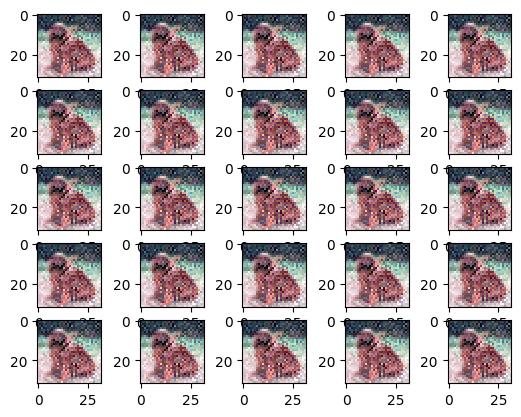

In [8]:
idx = 101

fig, axes = plt.subplots(5, 5)
axes_flat = axes.flat 
my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

for i in range(25):
    x = interpolation[idx][i]
    ax = next(axes_flat)
    ax.imshow(convert_to_img(x))

check gradient of baseline

In [1]:
import random
import os
import torch
import torchvision
import numpy as np 
import argparse
from tqdm import tqdm
import json
from distutils.util import strtobool

from ig_pkg.utils.eval import Cifar10Evaluator
from ig_pkg.utils.metrics import * #morf, lerf, 
from ig_pkg.utils.attribution import *

sample_result_dict = {}
average_result_dict = {}

In [6]:
path = {
    'zero': '/home/dhlee/results/cifar10/image_linear_zero_interpolation.npy',
    'expected': '/home/dhlee/results/cifar10/image_linear_expected_interpolation.npy',
    
    'latent_linear': '/home/dhlee/results/cifar10/latent_linear_interpolation.npy',
    }



In [17]:
pbar = tqdm(range(len(valid_dataset)))
pbar.set_description(f" Attribtion [👾] | linear & gradient | ")

method = 'expected'
interpolation_path = path[method]
interpolation = torch.from_numpy(np.load(interpolation_path))

sample_result_dict[f'{method}'] =[]
for idx in pbar:    
    input, label = valid_dataset[idx]
    input = input.to(device)
    
    baseline = interpolation[idx][0]
    logit = model(baseline.unsqueeze(0).to(device))
    score = torch.softmax(logit, dim=-1)[:, label].item()
    sample_result_dict[f'{method}'].append(score)

 Attribtion [👾] | linear & gradient | : 100%|██████████| 10000/10000 [03:32<00:00, 47.07it/s]


In [18]:
average_result_dict[f'{method}'] = np.mean(sample_result_dict[f'{method}'])
average_result_dict[f'{method}']

0.10230340911733837

In [15]:
pbar = tqdm(range(len(valid_dataset)))
pbar.set_description(f" Attribtion [👾] | linear & gradient | ")

method = 'latent_linear'
interpolation_path = path[method]
interpolation = torch.from_numpy(np.load(interpolation_path))

attribution = []
sample_result_dict[f'{method}'] =[]
for idx in pbar:    
    input, label = valid_dataset[idx]
    input = input.to(device)
    
    baseline = interpolation[idx][-1].to(device)
    logit = model(baseline.unsqueeze(0).to(device))
    score = torch.softmax(logit, dim=-1)[:, label].item()
    sample_result_dict[f'{method}'].append(score)

    interp = linear_interpolation(input, 24, baseline).to(device) # tensor
    attrib = integrated_gradient(model, input, label, baseline, interp, device) # tensor
    
    attribution.append(attrib.detach().cpu())

attribution = torch.stack(attribution)
np.save(f'/home/dhlee/results/cifar10/{method}_interpolation_linear_attribution.npy', attribution.numpy())

average_result_dict[f'{method}'] = np.mean(sample_result_dict[f'{method}'])

average_result_dict[f'{method}']            

 Attribtion [👾] | linear & gradient | : 100%|██████████| 10000/10000 [18:04<00:00,  9.22it/s]


0.7982492831266056

In [19]:
average_result_dict

{'zero': 0.10000000158324837,
 'latent_linear': 0.7982492831266056,
 'expected': 0.10230340911733837}

In [20]:
save_dir = '/home/dhlee/code/ig_inversion/results/'

with open(os.path.join(save_dir, f"baseline_score_average_cifar10.json"), 'w') as f:
    json.dump(average_result_dict, f, indent=2, sort_keys=True)
    
with open(os.path.join(save_dir, f"baseline_score_samples_cifar10.json"), 'w') as f:
    json.dump(sample_result_dict, f, indent=2, sort_keys=True)  

Expected IG - when the label of baseline is different from that of given image

In [ ]:
device = 'cuda:0'
names = {
    'zero',
    'one',
    'min',
    'max',
    'scalar',
#     'encoder',
#     'optimizer',
#     'hybrid',
    'gaussian_blur',
    'gaussian',
    'uniform',
    'maximumdistance' 
}

# {'gaussian',
#  'gaussian_blur',
#  'max',
#  'maximumdistance',
#  'min',
#  'one',
#  'scalar',
#  'uniform',
#  'zero'}

index = 0 
# x,y = valid_datasets[index]
x = ferrot_tensor
y = 359

fig, axes = plt.subplots(2, (len(names)//2)+1, figsize=(2*len(names)//2, 2*2))
axes_flat = axes.flat 
my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

ax = next(axes_flat)
ax.imshow(convert_to_img(x))

AOPC = []
LODDs = []
Kendal = []
for name in names:
    print(name)
    a = []
    b = []
    try:
        b_generator =  get_baseline_generator(name, scalar = 0.3)
        baseline = b_generator(x=x,y=y)

    except Exception as e: 
        print("-----")
        print("fail:", name)
        print(e)
        continue
        
    attr = ig(eval_mode.to(device), x, y, baseline, device=device)
    Kendal.append(kendal_correlation(eval_mode, ferrot_tensor, baseline, attr.detach().cpu().numpy(), device))

#     print(name)
    for i in range(19):
#         k = i * 5 + 5        
        k = i + 1
        aopc, lodds = pipeline(eval_mode, ferrot_tensor.to(device), baseline, attr, k, device, name)
        
#         print(name, k, aopc, lodds)
        a.append(aopc)
        b.append(lodds)
    
    attr, kwargs  = process_heatmap(attr.cpu(), my_cmap)
    ax = next(axes_flat)
    ax.imshow(attr, **kwargs)
    ax.set_title(name)
    ax.axis("off")
    
    AOPC.append(a)
    LODDs.append(b)    
    
plt.tight_layout()